This data was provided by Transport for NSW. It is Night Bus Origin-Destination  pair data.


In [219]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 2)

import seaborn as sns
sns.set(font_scale=0.6)

import geopy as gpd

# Import and transform data


use
``` python
df_raw = pd.read_pickle('ODPairData/df_raw.pkl')

```


In [169]:
df_raw = pd.read_excel('ODPairData/Late Night Bus OD_pairs_data Aug-Dec 2016 20170119 Final.xlsx')            
df_raw = df_raw.rename(columns={"Calendardate":"Date", "Origin location":"Origin", "Destination location":"Destination", "Hour start band": "Bands"})

In [175]:
df_raw.Origin = df_raw.Origin.astype('category')
df_raw.Destination = df_raw.Destination.astype('category')
df_raw.Mode = df_raw.Mode.astype('category')

In [176]:
BANDS = ["{0:} - {0:}:59".format(i) for i in range(0, 5)]
df_raw.Bands = df_raw.Bands.astype('category', ordered=True,  categories=BANDS)

In [177]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142649 entries, 0 to 142648
Data columns (total 6 columns):
Date           142649 non-null datetime64[ns]
Origin         142649 non-null category
Destination    142649 non-null category
Bands          142649 non-null category
Mode           142649 non-null category
Totaltrips     142649 non-null int64
dtypes: category(4), datetime64[ns](1), int64(1)
memory usage: 2.9 MB


In [178]:
print("Destination 'No tap off' {:.1f}% by count or {:.1f} by trips".format(len(df_raw.query('Destination == "No tap off"'))/len(df_raw) *100, 
          df_raw.query('Destination == "No tap off"').Totaltrips.sum()/df_raw.Totaltrips.sum() *100))

Destination 'No tap off' 6.5% by count or 6.2 by trips


In [179]:
df_raw = df_raw.query('Destination != "No tap off"')

In [180]:
df_raw.to_pickle('ODPairData/df_raw.pkl')

# Create cleaned data

Use 

df = pd.read_pickle('ODPairData/df_clean.pkl')

In [188]:
df_raw = pd.read_pickle('ODPairData/df_raw.pkl')
df_Destination = pd.read_pickle('ODPairData/df_Destination.pkl')

In [189]:
df = df_raw.merge(df_Destination, on='Destination', how='left')[['Date', 'Origin', 'Destination', 'Bands', 'Mode', 'Totaltrips', 'LGA', 'Suburb']]

In [190]:
df.Destination = df.Destination.astype('category')
df.LGA =         df.LGA.astype('category')
df.Suburb =         df.Suburb.astype('category')

In [191]:
BANDS = ["{0:} - {0:}:59".format(i) for i in range(0, 5)]
df.Bands = df.Bands.astype('category', ordered=True,  categories=BANDS)

df.Mode = df.Mode.astype('category')

In [192]:
df['From'] = df.Origin.apply(lambda s: s.split(',')[0].split('-')[0])
df.From = df.From.astype('category')
df.Origin = df.Origin.astype('category')

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133394 entries, 0 to 133393
Data columns (total 9 columns):
Date           133394 non-null datetime64[ns]
Origin         133394 non-null category
Destination    133394 non-null category
Bands          133394 non-null category
Mode           133394 non-null category
Totaltrips     133394 non-null int64
LGA            133394 non-null category
Suburb         133381 non-null category
From           133394 non-null category
dtypes: category(7), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


In [194]:
df.Bands = df.Bands.cat.rename_categories(['Midnight', '1AM', '2AM', '3AM', '4AM'])

In [195]:
df['Night'] = df.Date.dt.weekday_name.astype('category', ordered=True,  categories=['Friday', 'Saturday', 'Sunday', 'Monday'])

In [196]:
df.to_pickle('ODPairData/df_clean.pkl')

# Analysis

In [85]:
df = pd.read_pickle('ODPairData/df_clean.pkl')

In [86]:
df.Date.min(), df.Date.max()

(Timestamp('2016-08-01 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [87]:
df.From.cat.categories

Index(['Bondi Junction Station', 'Central Station', 'Circular Quay',
       'Kings Cross Station', 'Martin Place Station', 'Newtown Station',
       'North Sydney Station', 'Parramatta Interchange ', 'Town Hall House',
       'Town Hall Station'],
      dtype='object')

In [88]:
def dest(df, start):

    return (df.query('From == @start').
                 groupby(['LGA', 'Night']).Totaltrips.agg(sum).to_frame().reset_index().
                 pivot_table(index='LGA', columns='Night', aggfunc='sum', margins=True).
                 dropna().
                 sort_values([('Totaltrips', 'All')], ascending=False))

In [89]:
dest(df, "Kings Cross Station")

Totaltrips                               
Night         Friday Saturday Sunday Monday     All
LGA                                                
All            433.0    817.0  138.0   45.0  1433.0
Sydney         265.0    547.0   72.0   17.0   901.0
Waverley       137.0    236.0   35.0   19.0   427.0
Woollahra       29.0     34.0   31.0    9.0   103.0

In [90]:
dest(df, "Central Station").head()

Totaltrips                                   
Night            Friday Saturday   Sunday  Monday      All
LGA                                                       
All             16374.0  19719.0  12313.0  8111.0  56517.0
Sydney           6080.0   6832.0   4143.0  2523.0  19578.0
Marrickville     1694.0   1930.0    957.0   709.0   5290.0
Canterbury        844.0   1048.0    752.0   502.0   3146.0
Rockdale          772.0    987.0    816.0   485.0   3060.0

In [187]:
df.groupby(['LGA']).Totaltrips.agg(sum).sort_values(ascending=False)

LGA
Sydney              52862
Waverley            18548
Parramatta          13109
Rockdale            12810
Marrickville        12367
Randwick            12082
Canterbury          11022
City of Kogarah      9233
Strathfield          9126
Ryde                 8863
Auburn               8561
Ashfield             7085
Willoughby           6434
Canada Bay           6089
Burwood              5158
Leichhardt           4531
Blacktown            4454
Ku-Ring-Gai          3370
Woollahra            3108
Liverpool            2529
Campbelltown         2515
North Sydney         2415
Holroyd              2295
Fairfield            2078
Bankstown            1897
Hornsby              1666
Sutherland Shire     1599
Botany Bay           1487
Wollongong           1108
Hurstville            960
Hunters Hill          766
Penrith               589
The Hills Shire       416
Bogan                 362
Hawkesbury            212
Lane Cove             195
Manly                  92
Mosman                 69
Warringa

In [ ]:
df.groupby(['LGA']).Totaltrips.agg(sum).sort_values

# Visualisation

- vincent http://wrobstory.github.io/2013/04/python-maps-choropleth.html
- folium, geopands https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/

Postcodes
abs http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/2923.0.30.0012006

electorial commision, PCOde to LGA http://www.elections.nsw.gov.au/about_elections/electoral_boundaries/postcode_locality_list


https://data.gov.au/dataset/nsw-suburb-locality-boundaries-psma-administrative-boundaries

In [50]:
df = pd.read_pickle('ODPairData/df_clean.pkl')

## folium

https://gist.github.com/sjsrey/6802208

In [57]:
import json
import folium
import numpy as np

In [58]:
geo_str = json.dumps(json.load(open('NSW LGA.json', 'r')))

In [ ]:
mapa = folium.Map(location=[-15.80, -47.88],
                  tiles="Mapbox Bright",
                  zoom_start=3)
mapa

In [ ]:
threshold_scale = np.linspace(df['2013'].min(),
                              df['2013'].max(), 6, dtype=int).tolist()



mapa.geo_json(geo_str=geo_str,
              data=df,
              columns=['state', '2013'],
              fill_color='YlGn',
              key_on='feature.id',
              threshold_scale=threshold_scale)

mapa

## Geopandas

Get data from https://data.gov.au/dataset?tags=Boundaries

In [150]:
import geopandas as gp
from shapely.geometry import box

### LGA

In [151]:
gdf_LGA = gp.read_file('geodata/NSW_LGA.shp')[['nsw_lga__3', 'geometry']]

- nsw_lga__3 = LGA names?
- nsw_lga__2 = name of council
    

In [152]:
gdf_LGA = gdf_LGA.rename(columns={'nsw_lga__3':'LGA'}).query('LGA != "UNINCORPORATED"')

In [153]:
gdf_LGA.head()

,LGA,geometry
18,MAITLAND,"(POLYGON ((151.48999291 -32.6104182, 151.48994..."
19,BROKEN HILL,"(POLYGON ((141.56347702 -31.8849776, 141.55776..."
20,BEGA VALLEY,"(POLYGON ((149.63534931 -36.12844024, 149.6356..."
21,MURRAY RIVER,"(POLYGON ((143.90218147 -34.33132222, 143.9025..."
22,HAY,"(POLYGON ((144.8019946 -33.51228339, 144.81921..."


In [154]:
df_totals=df.groupby(['LGA']).Totaltrips.agg(sum).to_frame().reset_index()
df_totals.LGA = df_totals.LGA.apply(str.upper)
df_map = gp.GeoDataFrame(df_totals.merge(gdf_LGA, on='LGA'), crs=gdf_LGA.crs)

In [160]:
df_map.query('LGA == "BOGAN"')

,LGA,Totaltrips,geometry
1,BOGAN,362,"(POLYGON ((146.56180343 -30.84915753, 146.5813..."


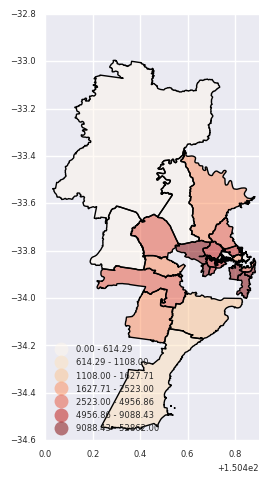

In [172]:
df_map.query("LGA not in ['NEWCASTLE', 'BOGAN']").plot(column='Totaltrips', scheme='QUANTILES', k=7, cmap='OrRd', legend=True, label='LGA')

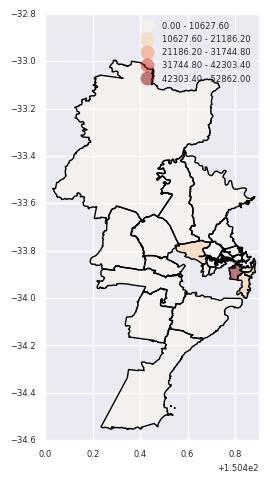

In [174]:
df_map.query("LGA not in ['NEWCASTLE', 'BOGAN']").plot(column='Totaltrips', scheme='Equal_Interval', k=5, cmap='OrRd', legend=True, label='LGA')

## Suburb 

In [197]:
df = pd.read_pickle('ODPairData/df_clean.pkl')

In [178]:
gdf_Suburb = gp.read_file('geodata/NSW_Suburb.shp')[['nsw_loca_2', 'geometry']]

In [180]:
gdf_Suburb = gdf_Suburb.rename(columns={'nsw_loca_2':'Suburb'})

In [204]:
df_totals=df.groupby(['Suburb']).Totaltrips.agg(sum).to_frame().reset_index()
df_totals.Suburb = df_totals.Suburb.apply(str.upper)

In [205]:
df_map = gp.GeoDataFrame(df_totals.merge(gdf_Suburb, on='Suburb'), crs=gdf_Suburb.crs)

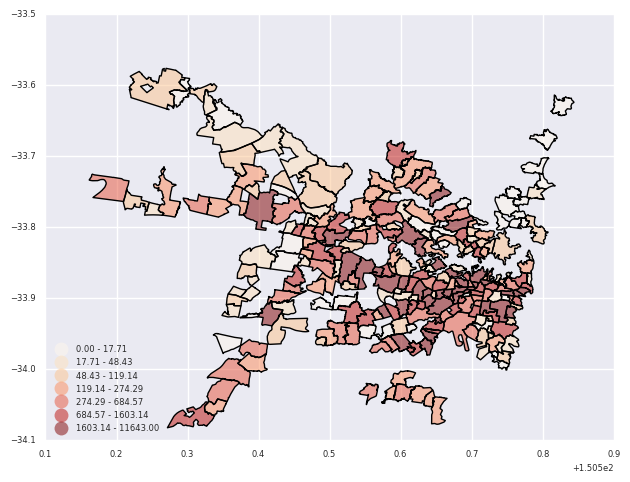

In [215]:
df_map[df_map.within(box(150, -34.5, 152, -33))].plot(column='Totaltrips', scheme='QUANTILES', k=7, cmap='OrRd', legend=True)

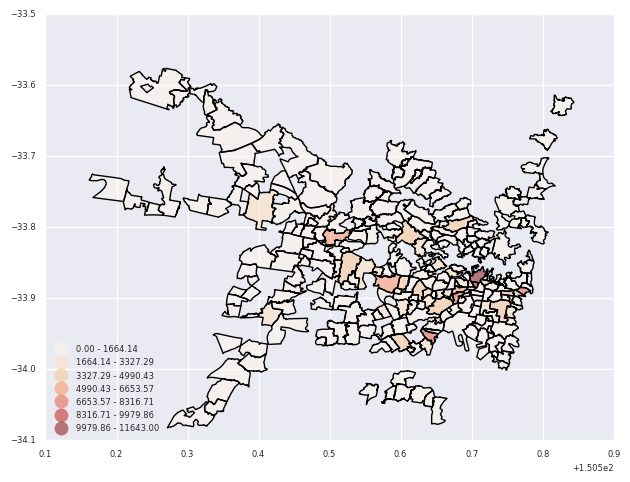

In [217]:
df_map[df_map.within(box(150, -34.5, 152, -33))].plot(column='Totaltrips', scheme='Equal_Interval', k=7, cmap='OrRd', legend=True)

## PySAL
See [Notebook](http://nbviewer.jupyter.org/github/pysal/pysal/blob/master/pysal/contrib/viz/mapping_guide.ipynb?create=1)

See [LISA](http://nbviewer.jupyter.org/urls/gist.githubusercontent.com/darribas/657e0568df7a63362762/raw/pysal_lisa_maps.ipynb)

In [143]:
from pysal.contrib.viz import mapping as maps
import pysal as ps

In [144]:
shp_link = ps.examples.get_path('geodata/NSW_LGA.shp')


KeyError: 'geodata/NSW_LGA.shp not found in PySAL built-in examples.'

In [147]:
maps.plot_choropleth('geodata/NSW_LGA.shp', df_totals, 'classless', title='LGA')

FileNotFoundError: [Errno 2] No such file or directory: 'geodata/NSW_LGA.shx'

In [142]:
gdf_LGA.head()

,LGA,geometry,centroid
18,MAITLAND,"(POLYGON ((151.48999291 -32.6104182, 151.48994...",POINT (151.550214211151 -32.71097836941808)
19,BROKEN HILL,"(POLYGON ((141.56347702 -31.8849776, 141.55776...",POINT (141.4785113135922 -31.94436096403665)
20,BEGA VALLEY,"(POLYGON ((149.63534931 -36.12844024, 149.6356...",POINT (149.7175898641389 -36.82593625015375)
21,MURRAY RIVER,"(POLYGON ((143.90218147 -34.33132222, 143.9025...",POINT (144.211315826591 -35.32437778622286)
22,HAY,"(POLYGON ((144.8019946 -33.51228339, 144.81921...",POINT (144.6836742143779 -34.31586966668706)


In [145]:
maps.plot_choropleth?

In [146]:
df_totals

,LGA,Totaltrips
0,ASHFIELD,7085
1,AUBURN,8561
2,BANKSTOWN,1897
3,BLACKTOWN,4454
4,BOGAN,362
5,BOTANY BAY,1487
6,BURWOOD,5158
7,CAMPBELLTOWN,2515
8,CANADA BAY,6089
9,CANTERBURY,11022
